(275, 2, 2035, 252)


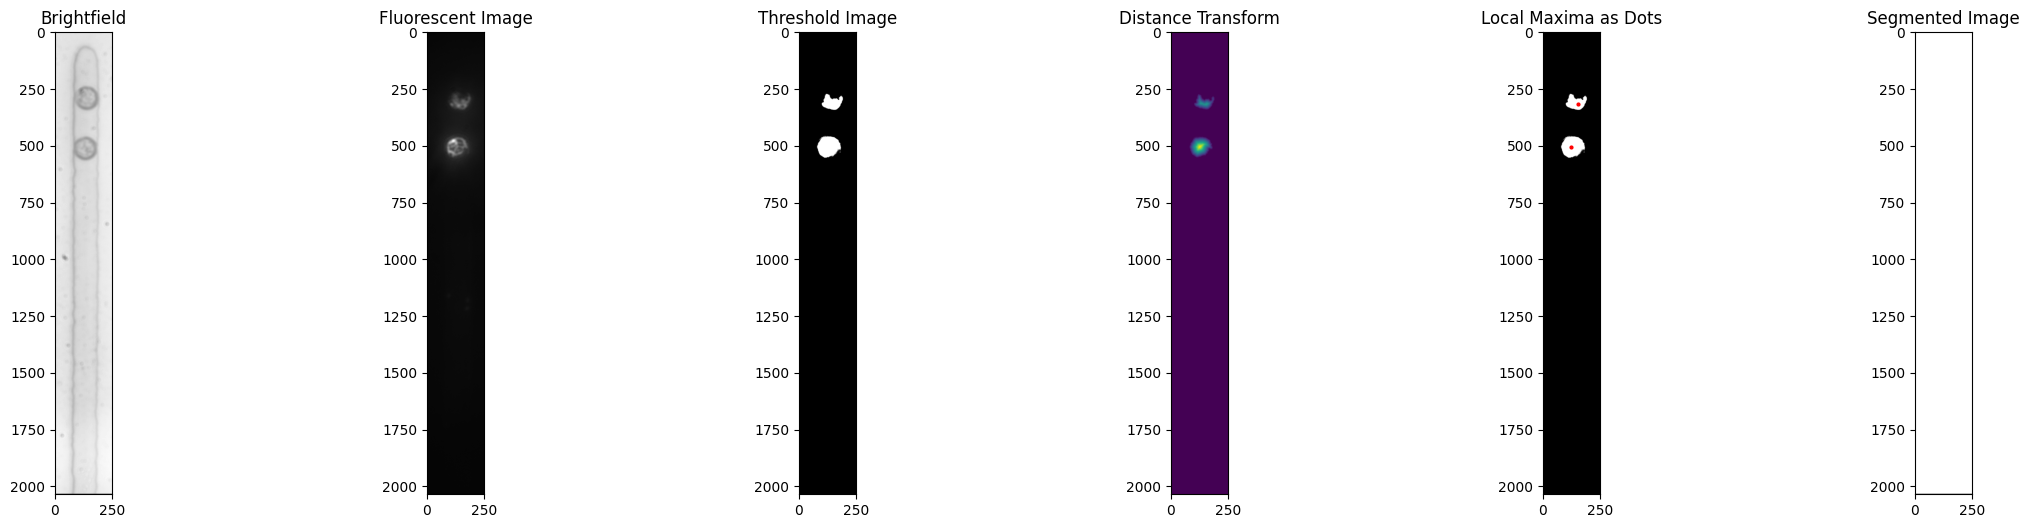

In [207]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tifffile
from skimage.feature import peak_local_max
from skimage import img_as_ubyte
#from skimage import segmentation
#from Watershed import *
import tempfile
import os

tifffile_image = tifffile.imread(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\trap_1_all_frames_series.tiff")
print(tifffile_image.shape)

fluorescent_image = tifffile_image[1, 1, :, :]
brightfield_image = tifffile_image[1, 0, :, :]

# Convert the fluorescent image to uint8 for compatibility with skimage functions

# Thresholding
threshold = cv2.threshold(fluorescent_image, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
threshold = threshold.astype(np.uint8)

# Distance Transform
dist_transform = cv2.distanceTransform(threshold, cv2.DIST_L2, 3)

# Find local maxima
local_max_location = peak_local_max(dist_transform, min_distance=25)

markers, _ = ndi.label(np.zeros_like(dist_transform))
markers[local_max_location[:, 0], local_max_location[:, 1]] = 1  # Set marker labels at local maxima


# Apply watershed segmentation
segmented = segmentation.watershed(brightfield_image, markers))

# Create a subplot with 1 row and 7 columns
fig, axes = plt.subplots(1, 6, figsize=(28, 6))

# Display the images in the desired order
axes[0].imshow(brightfield_image, cmap='gray')
axes[0].set_title('Brightfield')

axes[1].imshow(fluorescent_image, cmap='gray')
axes[1].set_title('Fluorescent Image')

axes[2].imshow(threshold, cmap='gray')
axes[2].set_title('Threshold Image')

axes[3].imshow(dist_transform, cmap='viridis')
axes[3].set_title('Distance Transform')

axes[4].imshow(threshold, cmap='gray')
axes[4].plot(local_max_location[:, 1], local_max_location[:, 0], 'ro', markersize=2)
axes[4].set_title('Local Maxima as Dots')

axes[5].imshow(segmented, cmap='gray')  # Change cmap as desired
axes[5].set_title('Segmented Image')

plt.show()


(275, 2, 2035, 252)
Seed Point - Label ID: 1, Area: 4040 pixels, Centroid: (143, 310)
Seed Point - Label ID: 8, Area: 7234 pixels, Centroid: (127, 504)


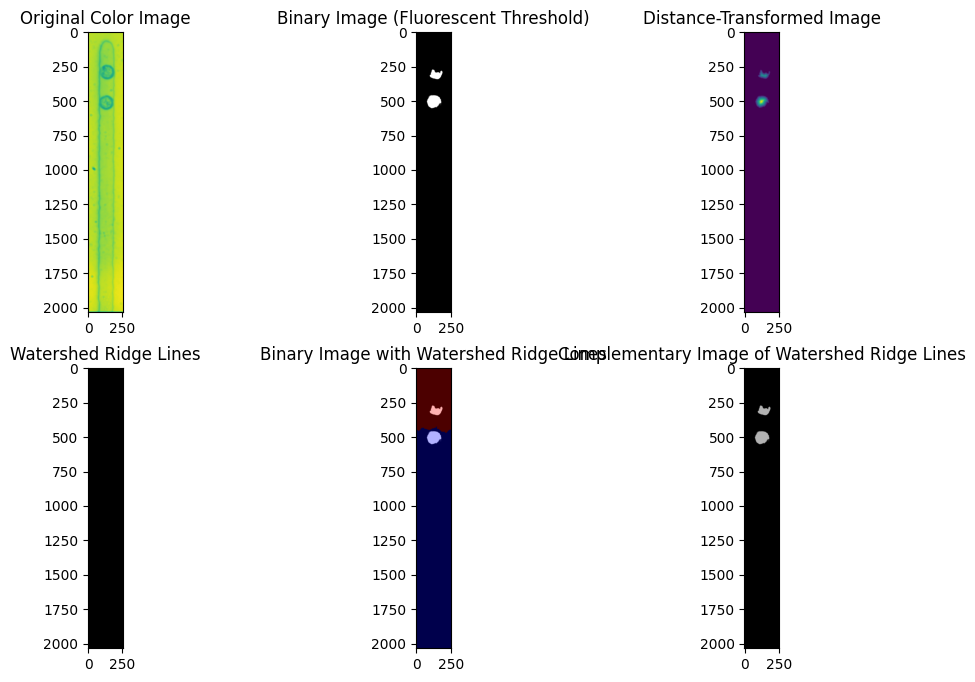

In [113]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tifffile
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import morphology, color

tifffile_image = tifffile.imread(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\trap_1_all_frames_series.tiff")
print(tifffile_image.shape)

# Load your fluorescent and brightfield images
fluorescent_image = tifffile_image[1, 1, :, :]
brightfield_image = tifffile_image[1, 0, :, :]

# Apply Otsu's thresholding to fluorescent image
_, binary_image = cv2.threshold(fluorescent_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
binary_image = binary_image.astype(np.uint8)
# Find cell locations and centroids
analysis = cv2.connectedComponentsWithStats(binary_image, 4, cv2.CV_32S)
(totalLabels, label_ids, values, centroids) = analysis

# Minimum area threshold for filtering
min_area_threshold = 100  # Adjust as needed

# Print area, label ID, and centroids for each label, filtered by area
for label in range(1, totalLabels):  # Start from 1 to skip background label
    area = values[label][4]
    if area >= min_area_threshold:
        centroid = tuple(map(int, centroids[label]))
        print(f"Seed Point - Label ID: {label}, Area: {area} pixels, Centroid: {centroid}")

# Create an empty marker image
markers = np.zeros_like(brightfield_image, dtype=np.int32)

# Assign labels as markers, filtered by area
for label in range(1, totalLabels):  # Start from 1 to skip background label
    area = values[label][4]
    if area >= min_area_threshold:
        markers[label_ids == label] = label

# Convert the marker image to 32-bit single-channel
markers = markers.astype(np.int32)

# Apply watershed segmentation using skimage on color brightfield image
segmentation = watershed(brightfield_image, markers)

# Ridge lines using distance transform
distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
local_max_location = peak_local_max(distance_transform, min_distance=1)
ridge_lines = morphology.skeletonize(segmentation == 0)

# Overlay ridge lines on the original binary image
overlay = color.label2rgb(segmentation, image=binary_image, bg_label=0, alpha=0.3, image_alpha=1, kind='overlay')

# Complementary image of watershed ridge lines superimposed on the binary image
complementary_overlay = color.label2rgb(ridge_lines, image=binary_image, bg_label=0, alpha=0.3, image_alpha=1, kind='overlay')

# Plotting
plt.figure(figsize=(12, 8))

# Original Color Image
plt.subplot(2, 3, 1)
plt.imshow(brightfield_image)
plt.title('Original Color Image')

# Binary Image (Fluorescent Image Thresholded)
plt.subplot(2, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image (Fluorescent Threshold)')

# Distance-Transformed Image
plt.subplot(2, 3, 3)
plt.imshow(distance_transform, cmap='viridis')
plt.title('Distance-Transformed Image')

# Watershed Ridge Lines
plt.subplot(2, 3, 4)
plt.imshow(ridge_lines, cmap='gray')
plt.title('Watershed Ridge Lines')

# Original Binary Image Overlaid with Watershed Ridge Lines
plt.subplot(2, 3, 5)
plt.imshow(overlay)
plt.title('Binary Image with Watershed Ridge Lines')

# Complementary Image of Watershed Ridge Lines Superimposed on Binary Image
plt.subplot(2, 3, 6)
plt.imshow(complementary_overlay)
plt.title('Complementary Image of Watershed Ridge Lines')

plt.show()
